---
title: "4. Updating value across trials"
---

# Updating value across trials

So far, we've implemented a function that will select an action and update its value estimate based on the reward received for a **single trial**. Here, we will extend this to a sequence of trials.


## Imports

First, we import necessary packages.


In [30]:
import jax
import numpy as np
import jax.numpy as jnp
from behavioural_modelling.decision_rules import softmax
from behavioural_modelling.utils import choice_from_action_p
from typing import Tuple
import matplotlib.pyplot as plt
import colormaps as cmaps
import os, requests
from matplotlib import font_manager, pyplot as plt

# Some code to make figures look nicer
url = 'https://github.com/google/fonts/blob/main/ofl/heebo/Heebo%5Bwght%5D.ttf?raw=true'
r = requests.get(url)
if r.status_code == 200:
    with open('./Heebo.ttf', 'wb') as f: f.write(r.content)
font_manager.fontManager.addfont('./Heebo.ttf')
plt.rcParams.update({'lines.linewidth': 1, 'lines.solid_capstyle': 'butt', 'legend.fancybox': True, 'axes.facecolor': 'fafafa', 'savefig.edgecolor': 'fafafa', 'savefig.facecolor': 'fafafa', 'figure.subplot.left': 0.08, 'figure.subplot.right': 0.95, 'figure.subplot.bottom': 0.07, 'figure.facecolor': 'fafafa', 'figure.dpi': 80, 'lines.color': '383838', 'patch.edgecolor': '383838', 'text.color': '383838', 'axes.edgecolor': '383838', 'axes.labelcolor': '383838', 'xtick.color': '616161', 'ytick.color': '616161', 'font.family': 'Heebo', 'font.weight': 'regular', 'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10})


## Looping over trials using `jax.lax.scan`

As mentioned in [this guide](/docs/computational_modelling/guide/1.-building-basic-models/#looping-over-trials), we can't use a simple for loop to iterate over trials in JAX. Instead, we can use [`jax.lax.scan`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) to loop over trials.

The `scan` function can be a bit confusing, but works in quite a simple way. We have a variable `y` that we want to update based on a sequence of inputs `x`, changing its value at every step. So, in our example `y` is the expected value, and we want to update it based on a sequence of trial outcomes (rewards), which are our `x`. 

We do this based on an update function `f` (as we've been implementing so far). Our function should take two inputs: the current state of `y` (here, our expected value) and the current input `x` (here, the trial outcomes), and return two outputs: the updated state of `y` and any other output (e.g., prediction errors) for the current iteration.

For most purposes, the `scan` function takes three inputs:
* `f`: our update function, as described above. Here, this will be our Rescorla-Wagner update function.
* `init`: the initial value of `y`, before we update it. Here, this will be our starting expected value.
* `xs`: the sequence of inputs `x` that we want to iterate over. Here, this will be our trial outcomes (rewards).

### Rewriting our function to be slightly more JAX-friendy

Here, we encounter another of JAX's peculiarities: our function requires a random key to passed to it to randomly generate choices on each trial. This means that we will need a new random key for each trial, which means that we will need to pass in a random key sequence as an input to our function, just like we pass in our trial outcomes as a sequence.

However, our function can only take **two** inputs: the current state of `y` and the current input `x`. Here, we want `x` to be **both** our trial outcomes **and** our random key sequence. To do this, we can pass in a tuple of `(reward, key)` as our input `x`, and then unpack this tuple inside our function.

In [75]:
@jax.jit
def asymmetric_rescorla_wagner_update(
    value: jax.typing.ArrayLike,
    outcome: jax.typing.ArrayLike,
    chosen: jax.typing.ArrayLike,
    alpha_p: float,
    alpha_n: float,
) -> Tuple[jax.typing.ArrayLike, jax.typing.ArrayLike]:
    """
    Updates the estimated value of a state or action using the Asymmetric Rescorla-Wagner learning rule.

    The function calculates the prediction error as the difference between the actual outcome and the current
    estimated value. It then updates the estimated value based on the prediction error and the learning rate,
    which is determined by whether the prediction error is positive or negative.

    Value estimates are only updated for chosen actions. For unchosen actions, the prediction error is set to 0.

    Args:
        value (float): The current estimated value of a state or action.
        outcome (float): The actual reward received.
        chosen (float): Binary indicator of whether the action was chosen (1) or not (0).
        alpha_p (float): The learning rate used when the prediction error is positive.
        alpha_n (float): The learning rate used when the prediction error is negative.

    Returns:
        Tuple[float, float]: The updated value and the prediction error.
    """

    # Calculate the prediction error
    prediction_error = outcome - value

    # Set prediction error to 0 for unchosen actions
    prediction_error = prediction_error * chosen

    # Set the learning rate based on the sign of the prediction error
    alpha_t = (alpha_p * (prediction_error > 0)) + (alpha_n * (prediction_error < 0))

    # Update the value
    value = value + alpha_t * prediction_error

    return value, prediction_error

def asymmetric_rescorla_wagner_update_choice(
    value: jax.typing.ArrayLike,
    outcome_key: Tuple[jax.typing.ArrayLike, jax.random.PRNGKey],
    alpha_p: float,
    alpha_n: float,
    temperature: float,
    n_actions: int,
) -> np.ndarray:
    """
    Updates the value estimate using the asymmetric Rescorla-Wagner algorithm, and chooses an
    option based on the softmax function.

    Args:
        value (jax.typing.ArrayLike): The current value estimate.
        outcome_key (Tuple[jax.typing.ArrayLike, jax.random.PRNGKey]): A tuple containing the outcome and the PRNG key.
        alpha_p (float): The learning rate for positive outcomes.
        alpha_n (float): The learning rate for negative outcomes.
        temperature (float): The temperature parameter for softmax function.
        n_actions (int): The number of actions to choose from.

    Returns:
        Tuple[np.ndarray, Tuple[jax.typing.ArrayLike, np.ndarray, int, np.ndarray]]:
            - updated_value (jnp.ndarray): The updated value estimate.
            - output_tuple (Tuple[jax.typing.ArrayLike, np.ndarray, int, np.ndarray]):
                - value (jax.typing.ArrayLike): The original value estimate.
                - choice_p (jnp.ndarray): The choice probabilities.
                - choice (int): The chosen action.
                - choice_array (jnp.ndarray): The chosen action in one-hot format.
    """

    # Unpack outcome and key
    outcome, key = outcome_key

    # Get choice probabilities
    choice_p = softmax(value[None, :], temperature).squeeze()

    # Get choice
    choice = choice_from_action_p(key, choice_p)

    # Convert it to one-hot format
    choice_array = jnp.zeros(n_actions, dtype=jnp.int16)
    choice_array = choice_array.at[choice].set(1)

    # Get the outcome and update the value estimate
    updated_value, prediction_error = asymmetric_rescorla_wagner_update(
        value,
        outcome,
        choice_array,
        alpha_p,
        alpha_n,
    )

    return updated_value, (value, choice_p, choice_array, prediction_error)

asymmetric_rescorla_wagner_update_choice = jax.jit(asymmetric_rescorla_wagner_update_choice, static_argnums=(5,))

Now, rather than having an `outcome` argument and a `key` argument, we have:

```python
outcome_key: Tuple[jax.typing.ArrayLike, jax.random.PRNGKey]
```

This is a tuple of `(reward, key)`, which we can unpack inside our function as follows:

```python
outcome, key = outcome_key
```

This means our function now takes a single `x` input, as required by `scan`.

## Fixing parameter values using `partial`

There's another issue we need to address. Our function takes various other parameters: `alpha_p`, `alpha_n`, `temperature`, and `n_actions`. We can't pass these directly to `scan`, as our function needs to have only two inputs. We could pass them in every trial within a single tuple, as we've done above with the outcome and key, but this would be excessive since they don't change across trials.

Instead, we can use the `functools.partial` function to fix these parameters in our function. This will create a new function that only takes the `y` and `x` inputs, with the other parameters already set.

In [76]:
from functools import partial

# Set parameter values
alpha_p = 0.1
alpha_n = 0.9
temperature = 0.5

# Use partial to create a function with fixed parameters
asymmetric_rescorla_wagner_update_choice_partial = partial(
    asymmetric_rescorla_wagner_update_choice,
    alpha_p=alpha_p,
    alpha_n=alpha_n,
    temperature=temperature,
    n_actions=5,
)

This gives us a new function `asymmetric_rescorla_wagner_update_choice_partial` that only takes the `y` and `x` inputs, with the other parameters already set. We can then pass this new function to `scan`.

## Using `scan`

### Setting up the "task"

First, let's set up some outcomes for our task. We'll start with 100 trials, and randomly generate rewards for each of our 5 stimuli such that they have different levels of rewards.

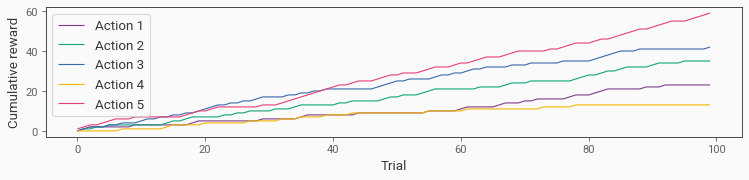

In [73]:
# Number of trials
N_TRIALS = 100

# Reward probabilities for each of our 5 actions
reward_probs = jnp.array([0.2, 0.4, 0.3, 0.1, 0.5])

# Generate rewards for each trial for each action using Numpy
# There's no need to use JAX for this
rng = np.random.default_rng(0)
rewards = rng.binomial(n=1, p=reward_probs, size=(N_TRIALS, len(reward_probs)))

# Plot the rewards
plt.figure(figsize=(10, 2))

for i in range(len(reward_probs)):
    plt.plot(np.cumsum(rewards[:, i]), label=f"Action {i + 1}", color=cmaps.bold(i))

plt.xlabel("Trial")
plt.ylabel("Cumulative reward")
plt.legend()

We can see that the cumulative rewards differ across the stimuli as they each have different reward probabilities.

### Running the model

We can now use `scan` to apply our model to this task. We'll start with an initial value of 0.5 for our expected value, and use some more sensible parameter values.

In [77]:
# Set parameter values
alpha_p = 0.1
alpha_n = 0.1
temperature = 0.1

# Use partial to create a function with fixed parameters
asymmetric_rescorla_wagner_update_choice_partial = partial(
    asymmetric_rescorla_wagner_update_choice,
    alpha_p=alpha_p,
    alpha_n=alpha_n,
    temperature=temperature,
    n_actions=5,
)

# Generate random keys using JAX
rng = jax.random.PRNGKey(0)
keys = jax.random.split(rng, N_TRIALS)

# Initialize the value estimates
value = jnp.ones(5) * 0.5

# Loop using scan
_, (values, choice_ps, choices, prediction_errors) = jax.lax.scan(
    asymmetric_rescorla_wagner_update_choice_partial,
    value,
    (rewards, keys),
)

Let's go through the key parts of this in a bit more detail.

#### Setting up random keys

```python
rng = jax.random.PRNGKey(0)
keys = jax.random.split(rng, N_TRIALS)
```

We need to set up a random key for each trial. We do this using `jax.random.split` to split our initial random key into a sequence of keys that is as long as the number of trials.

#### Running the `scan` loop

```python
_, (values, choice_ps, choices, prediction_errors) = jax.lax.scan(
    asymmetric_rescorla_wagner_update_choice_partial,
    value,
    (rewards, keys),
)
```

Here, we pass in:
* `asymmetric_rescorla_wagner_update_choice_partial`: our function that will be applied to each trial.
* `value`: our initial value for the expected value.
* `(rewards, keys)`: our sequence of inputs for each trial. This is a tuple of `(rewards, keys)`, where `rewards` is our sequence of trial outcomes and `keys` is our sequence of random keys.

The `scan` function will return the two variables that our function returns. We're only interested in the second one, which contains the values of the expected value at the start of each trial (prior to updating), the choice probabilities, the choices made, and the prediction errors. For this reason, we use `_` to ignore the first output.

### Plot the output

#### Expected value

We can plot the output of our model to see how the expected value changes across trials, as well as the choice probabilities, choices made, and prediction errors.

First, we'll plot the expected value across trials. 

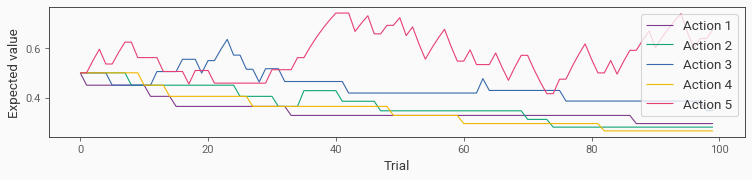

In [78]:
# Plot the estimated values
plt.figure(figsize=(10, 2))

for i in range(len(reward_probs)):
    plt.plot(values[:, i], label=f"Action {i + 1}", color=cmaps.bold(i))

plt.xlabel("Trial")
plt.ylabel("Expected value")
plt.legend()

As expected, the action with the highest value has the highest estimated value. This is a bit messy as the model will continue to respond to prediction errors and update its value estimate throughout the task.

#### Predictions errors

We can also plot the prediction errors across trials.

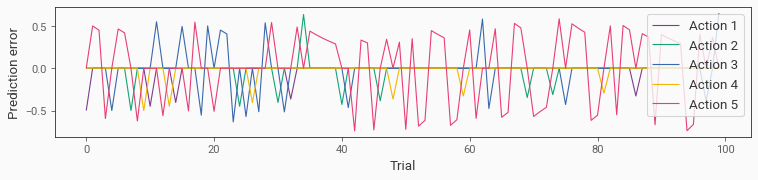

In [80]:
# Plot the estimated values
plt.figure(figsize=(10, 2))

for i in range(len(reward_probs)):
    plt.plot(prediction_errors[:, i], label=f"Action {i + 1}", color=cmaps.bold(i))

plt.xlabel("Trial")
plt.ylabel("Prediction error")
plt.legend()